# Dataset Split: Train/Val/Test with Stratification

This notebook performs **stratified splitting** of the annotated dataset from a CSV file, ensuring:
- **Video-level grouping**: All frames from the same video stay in the same split
- **Stratification**: Proportional distribution of background and target-containing videos across splits
- **Split ratio**: 70% train, 15% validation, 15% test
- **Output**: Three CSV files with image paths for use in model training

Strategy:
1. Load all images from the annotations.csv file
2. Group frames by source video
3. Classify videos as "background" (no targets) or "target" (has targets)
4. Use stratified sampling to ensure each split has balanced class proportions
5. Export train.csv, val.csv, test.csv with image paths

In [1]:
# Import Required Libraries
import os
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import defaultdict

print('✓ Libraries imported')

✓ Libraries imported


## Configuration and Paths

Update these paths to match your annotated output directory and desired CSV output location.

In [2]:
# Base project directory (used for relative pathing)
BASE_DIR = Path(r'F:\DeTect_TaiwanBirds_VideoDetector')

# Input dataset CSV file (contains image_path, video_name, num_targets, etc.)
DATASET_CSV_PATH = BASE_DIR / 'dataset' / 'csvs' / 'annotations.csv'

# Output directory for split CSV files
CSV_OUTPUT_DIR = BASE_DIR / 'dataset' / 'csvs' / 'splits'
CSV_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Split ratios
TRAIN_RATIO = 0.70  # 70%
VAL_RATIO = 0.15    # 15%
TEST_RATIO = 0.15   # 15%

# Random seed for reproducibility
RANDOM_SEED = 42

print(f'Dataset CSV: {DATASET_CSV_PATH}')
print(f'Dataset CSV exists: {DATASET_CSV_PATH.exists()}')
print(f'CSV output dir: {CSV_OUTPUT_DIR}')
print(f'Split ratios: Train={TRAIN_RATIO}, Val={VAL_RATIO}, Test={TEST_RATIO}')

Dataset CSV: F:\DeTect_TaiwanBirds_VideoDetector\dataset\csvs\annotations.csv
Dataset CSV exists: True
CSV output dir: F:\DeTect_TaiwanBirds_VideoDetector\dataset\csvs\splits
Split ratios: Train=0.7, Val=0.15, Test=0.15


## Load Dataset from CSV

Read the annotations CSV file and prepare it for stratified splitting.

In [3]:
# Load dataset from CSV
if not DATASET_CSV_PATH.exists():
    raise FileNotFoundError(f'Dataset CSV not found: {DATASET_CSV_PATH}')

df_images = pd.read_csv(DATASET_CSV_PATH)
print(f'✓ Loaded dataset from CSV')
print(f'DataFrame shape: {df_images.shape}')
# print(f'\nColumns in dataset: {list(df_images.columns)}')

print(f'\nDataset statistics:')
print(f'  Total images: {len(df_images)}')
print(f'  Unique videos: {df_images["video_name"].nunique()}')
if 'num_targets' in df_images.columns:
    print(f'  Total targets: {df_images["num_targets"].sum()}')

df_images

✓ Loaded dataset from CSV
DataFrame shape: (3713, 10)

Dataset statistics:
  Total images: 3713
  Unique videos: 301
  Total targets: 560


,image_path,image_width,image_height,image_format,num_targets,classes,has_annotations,video_path,video_name,frame_number
0,G:\2025-05-14_videos_annotated\images\A03_0000...,1920,1080,JPEG,0,Background,No,G:\2025-05-14\A03_0000cfa6-1efa-350e-a754-5e23...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,0
1,G:\2025-05-14_videos_annotated\images\A03_0000...,1920,1080,JPEG,2,Bird,Yes,G:\2025-05-14\A03_0000cfa6-1efa-350e-a754-5e23...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,124
2,G:\2025-05-14_videos_annotated\images\A03_0000...,1920,1080,JPEG,2,Bird,Yes,G:\2025-05-14\A03_0000cfa6-1efa-350e-a754-5e23...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,149
3,G:\2025-05-14_videos_annotated\images\A03_0000...,1920,1080,JPEG,0,Background,No,G:\2025-05-14\A03_0000cfa6-1efa-350e-a754-5e23...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,16
4,G:\2025-05-14_videos_annotated\images\A03_0000...,1920,1080,JPEG,2,Bird,Yes,G:\2025-05-14\A03_0000cfa6-1efa-350e-a754-5e23...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,174
...,...,...,...,...,...,...,...,...,...,...
3708,G:\2025-05-14_videos_annotated\images\A03_1b68...,1920,1080,JPEG,0,Background,No,G:\2025-05-14\A03_1b68d1f3-80ed-3efb-8f75-c5af...,A03_1b68d1f3-80ed-3efb-8f75-c5af2cfab643,224
3709,G:\2025-05-14_videos_annotated\images\A03_1b68...,1920,1080,JPEG,0,Background,No,G:\2025-05-14\A03_1b68d1f3-80ed-3efb-8f75-c5af...,A03_1b68d1f3-80ed-3efb-8f75-c5af2cfab643,24
3710,G:\2025-05-14_videos_annotated\images\A03_1b68...,1920,1080,JPEG,0,Background,No,G:\2025-05-14\A03_1b68d1f3-80ed-3efb-8f75-c5af...,A03_1b68d1f3-80ed-3efb-8f75-c5af2cfab643,49
3711,G:\2025-05-14_videos_annotated\images\A03_1b68...,1920,1080,JPEG,0,Background,No,G:\2025-05-14\A03_1b68d1f3-80ed-3efb-8f75-c5af...,A03_1b68d1f3-80ed-3efb-8f75-c5af2cfab643,74


## Group Images by Video

Create a video-level dataset where each video contains all its associated frames.

In [4]:
# Group images by video
videos_dict = defaultdict(list)
for _, row in df_images.iterrows():
    video_name = row['video_name']
    videos_dict[video_name].append({
        'image_path': row['image_path'],
        'num_targets': row['num_targets'],
        'frame_number': row['frame_number']
    })

# Create video-level dataframe
video_rows = []
for video_name, frames in videos_dict.items():
    # Calculate video-level statistics
    total_targets = sum(f['num_targets'] for f in frames)
    num_frames = len(frames)
    has_targets = 'target' if total_targets > 0 else 'background'
    
    video_rows.append({
        'video_name': video_name,
        'num_frames': num_frames,
        'total_targets': total_targets,
        'video_category': has_targets,
        'frames': frames  # Store frame info for later export
    })

df_videos = pd.DataFrame(video_rows)
print(f'✓ Grouped into {len(df_videos)} unique videos')
print(f'\nVideo statistics:')
print(f'  Total frames across all videos: {len(df_images)}')
print(f'  Avg frames per video: {len(df_images) / len(df_videos):.1f}')
print(f'  Min frames: {df_videos["num_frames"].min()}, Max frames: {df_videos["num_frames"].max()}')
print(f'  Total targets: {df_videos["total_targets"].sum()}')

✓ Grouped into 301 unique videos

Video statistics:
  Total frames across all videos: 3713
  Avg frames per video: 12.3
  Min frames: 10, Max frames: 64
  Total targets: 560


## Analyze Video Categories

Categorize videos as "background" (no targets) or "target" (has at least one target) and display category distribution.

In [5]:
# Analyze video categories
category_counts = df_videos['video_category'].value_counts()
print('Video Category Distribution:')
print(category_counts)
print()

# Calculate percentages
total_videos = len(df_videos)
for cat in ['background', 'target']:
    if cat in category_counts.index:
        count = category_counts[cat]
        pct = count / total_videos * 100
        print(f'  {cat:15s}: {count:3d} videos ({pct:5.1f}%)')

# Display stratification vector for train_test_split
print(f'\nStratification vector (used for stratified splitting):')
print(f'  This ensures each split gets balanced proportions of background vs target videos')
stratify_vector = df_videos['video_category'].values
print(f'  Vector length: {len(stratify_vector)}')
print(f'  Value counts: {pd.Series(stratify_vector).value_counts().to_dict()}')

Video Category Distribution:
video_category
background    250
target         51
Name: count, dtype: int64

  background     : 250 videos ( 83.1%)
  target         :  51 videos ( 16.9%)

Stratification vector (used for stratified splitting):
  This ensures each split gets balanced proportions of background vs target videos
  Vector length: 301
  Value counts: {'background': 250, 'target': 51}


## Stratified Video-Level Split

Perform stratified splitting to ensure proportional representation of background and target videos across all three splits (70% train, 15% val, 15% test).

**Strategy**: First split train+val (70%) from test (30%), then split train (70% of remainder) from val (30% of remainder).

In [6]:
# Reset index for clean splitting
df_videos_reset = df_videos.reset_index(drop=True)

# Step 1: Split into (train+val) 70% and (test) 30%
train_indices, test_val_indices = train_test_split(
    range(len(df_videos_reset)),
    test_size=0.30,  # 30% for test
    random_state=RANDOM_SEED,
    stratify=df_videos_reset['video_category']
)

train_df = df_videos_reset.loc[train_indices].reset_index(drop=True)
test_val_df = df_videos_reset.loc[test_val_indices].reset_index(drop=True)

# Step 2: Split the 30% into test 15% and val 15% of that portion
test_size_ratio = TEST_RATIO / (TEST_RATIO + VAL_RATIO)  # 15/(15+15)
val_indices_in_test, test_indices_in_test = train_test_split(
    range(len(test_val_df)),
    test_size=test_size_ratio,
    random_state=RANDOM_SEED,
    stratify=test_val_df['video_category']
)

test_df = test_val_df.loc[test_indices_in_test].reset_index(drop=True)
val_df = test_val_df.loc[val_indices_in_test].reset_index(drop=True)

print('✓ Stratified split complete')
print(f'\nSplit Summary:')
print(f'  Train: {len(train_df):3d} videos ({len(train_df)/len(df_videos)*100:5.1f}%)')
print(f'  Val:   {len(val_df):3d} videos ({len(val_df)/len(df_videos)*100:5.1f}%)')
print(f'  Test:  {len(test_df):3d} videos ({len(test_df)/len(df_videos)*100:5.1f}%)')
print(f'  Total: {len(train_df) + len(val_df) + len(test_df):3d} videos')

✓ Stratified split complete

Split Summary:
  Train: 210 videos ( 69.8%)
  Val:    45 videos ( 15.0%)
  Test:   46 videos ( 15.3%)
  Total: 301 videos


## Generate Split Statistics

Calculate detailed statistics for each split to verify proper stratification.

In [7]:
# Calculate statistics for each split
def calculate_split_stats(df, split_name):
    num_videos = len(df)
    num_images = sum(f['num_frames'] for _, f in df.iterrows())
    num_background_videos = (df['video_category'] == 'background').sum()
    num_target_videos = (df['video_category'] == 'target').sum()
    total_targets = df['total_targets'].sum()
    
    pct_bg = num_background_videos / num_videos * 100 if num_videos > 0 else 0
    pct_tg = num_target_videos / num_videos * 100 if num_videos > 0 else 0
    
    return {
        'split': split_name,
        'num_videos': num_videos,
        'num_images': num_images,
        'num_background_videos': num_background_videos,
        'num_target_videos': num_target_videos,
        'pct_background': pct_bg,
        'pct_target': pct_tg,
        'total_targets': total_targets
    }

stats_train = calculate_split_stats(train_df, 'Train')
stats_val = calculate_split_stats(val_df, 'Val')
stats_test = calculate_split_stats(test_df, 'Test')

stats_df = pd.DataFrame([stats_train, stats_val, stats_test])

print('\n' + '='*80)
print('DETAILED SPLIT STATISTICS')
print('='*80)
for idx, row in stats_df.iterrows():
    print(f"\n{row['split']} Set:")
    print(f"  Videos:              {row['num_videos']:4d} ({row['num_videos']/len(df_videos)*100:5.1f}% of total)")
    print(f"  Images:              {row['num_images']:4d} ({row['num_images']/len(df_images)*100:5.1f}% of total)")
    print(f"  Background videos:   {row['num_background_videos']:4d} ({row['pct_background']:5.1f}% of split)")
    print(f"  Target videos:       {row['num_target_videos']:4d} ({row['pct_target']:5.1f}% of split)")
    print(f"  Total targets:       {int(row['total_targets']):4d}")

print('\n' + '='*80)
print('Stratification Check:')
print('='*80)
overall_bg_ratio = (df_videos['video_category'] == 'background').sum() / len(df_videos) * 100
overall_tg_ratio = (df_videos['video_category'] == 'target').sum() / len(df_videos) * 100
print(f'Overall background ratio: {overall_bg_ratio:.1f}%')
print(f'Overall target ratio:     {overall_tg_ratio:.1f}%')
print()
for idx, row in stats_df.iterrows():
    print(f"{row['split']:5s} - BG: {row['pct_background']:5.1f}%, TG: {row['pct_target']:5.1f}%")


DETAILED SPLIT STATISTICS

Train Set:
  Videos:               210 ( 69.8% of total)
  Images:              2591 ( 69.8% of total)
  Background videos:    174 ( 82.9% of split)
  Target videos:         36 ( 17.1% of split)
  Total targets:        368

Val Set:
  Videos:                45 ( 15.0% of total)
  Images:               545 ( 14.7% of total)
  Background videos:     38 ( 84.4% of split)
  Target videos:          7 ( 15.6% of split)
  Total targets:        106

Test Set:
  Videos:                46 ( 15.3% of total)
  Images:               577 ( 15.5% of total)
  Background videos:     38 ( 82.6% of split)
  Target videos:          8 ( 17.4% of split)
  Total targets:         86

Stratification Check:
Overall background ratio: 83.1%
Overall target ratio:     16.9%

Train - BG:  82.9%, TG:  17.1%
Val   - BG:  84.4%, TG:  15.6%
Test  - BG:  82.6%, TG:  17.4%


## Export Train/Val/Test CSV Files

Create train.csv, val.csv, and test.csv files with only the image_path column.

In [8]:
# Collect all image paths for each split
def collect_image_paths(split_df):
    """Collect all image paths from all frames in split videos."""
    image_paths = []
    for _, row in split_df.iterrows():
        frames = row['frames']
        for frame in frames:
            image_paths.append(frame['image_path'])
    return image_paths

train_image_paths = collect_image_paths(train_df)
val_image_paths = collect_image_paths(val_df)
test_image_paths = collect_image_paths(test_df)

# Create CSV dataframes with only image_path column
train_csv_df = pd.DataFrame({'image_path': train_image_paths})
val_csv_df = pd.DataFrame({'image_path': val_image_paths})
test_csv_df = pd.DataFrame({'image_path': test_image_paths})

# Save CSV files
train_csv_path = CSV_OUTPUT_DIR / 'train.txt'
val_csv_path = CSV_OUTPUT_DIR / 'val.txt'
test_csv_path = CSV_OUTPUT_DIR / 'test.txt'

train_csv_df.to_csv(train_csv_path, index=False, header=False)
val_csv_df.to_csv(val_csv_path, index=False, header=False)
test_csv_df.to_csv(test_csv_path, index=False, header=False)

print('✓ CSV files exported successfully')
print(f'\nOutput files:')
print(f'  {train_csv_path}  ({len(train_csv_df)} rows)')
print(f'  {val_csv_path}    ({len(val_csv_df)} rows)')
print(f'  {test_csv_path}   ({len(test_csv_df)} rows)')

# Verify no duplicates across splits
all_paths = set(train_image_paths + val_image_paths + test_image_paths)
total_paths = len(train_image_paths) + len(val_image_paths) + len(test_image_paths)
if len(all_paths) == total_paths:
    print(f'\n✓ No image duplicates across splits')
else:
    print(f'\n⚠ WARNING: Found duplicate images across splits!')

# Verify all images are included
if len(all_paths) == len(df_images):
    print(f'✓ All {len(df_images)} images are included in splits')

✓ CSV files exported successfully

Output files:
  F:\DeTect_TaiwanBirds_VideoDetector\dataset\csvs\splits\train.txt  (2591 rows)
  F:\DeTect_TaiwanBirds_VideoDetector\dataset\csvs\splits\val.txt    (545 rows)
  F:\DeTect_TaiwanBirds_VideoDetector\dataset\csvs\splits\test.txt   (577 rows)

✓ No image duplicates across splits
✓ All 3713 images are included in splits


## Visualize Split Distribution

Create bar plots and pie charts to verify proper stratification across splits.

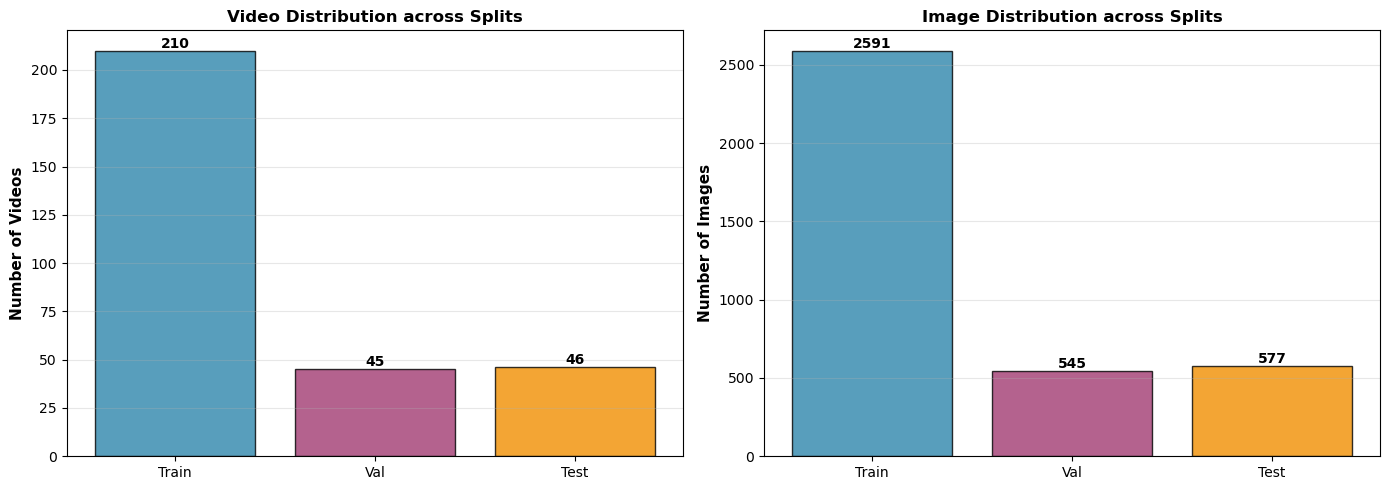

Counts:
  Train : 210 videos, 2591 images
  Val   :  45 videos,  545 images
  Test  :  46 videos,  577 images


In [9]:
# Visualization 1: Video Distribution across splits
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

splits = ['Train', 'Val', 'Test']
video_counts = [len(train_df), len(val_df), len(test_df)]
image_counts = [len(train_image_paths), len(val_image_paths), len(test_image_paths)]

# Videos per split
colors_splits = ['#2E86AB', '#A23B72', '#F18F01']
axes[0].bar(splits, video_counts, color=colors_splits, edgecolor='black', alpha=0.8)
axes[0].set_ylabel('Number of Videos', fontsize=11, fontweight='bold')
axes[0].set_title('Video Distribution across Splits', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(video_counts):
    axes[0].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Images per split
axes[1].bar(splits, image_counts, color=colors_splits, edgecolor='black', alpha=0.8)
axes[1].set_ylabel('Number of Images', fontsize=11, fontweight='bold')
axes[1].set_title('Image Distribution across Splits', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(image_counts):
    axes[1].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print('Counts:')
for split, videos, images in zip(splits, video_counts, image_counts):
    print(f'  {split:6s}: {videos:3d} videos, {images:4d} images')


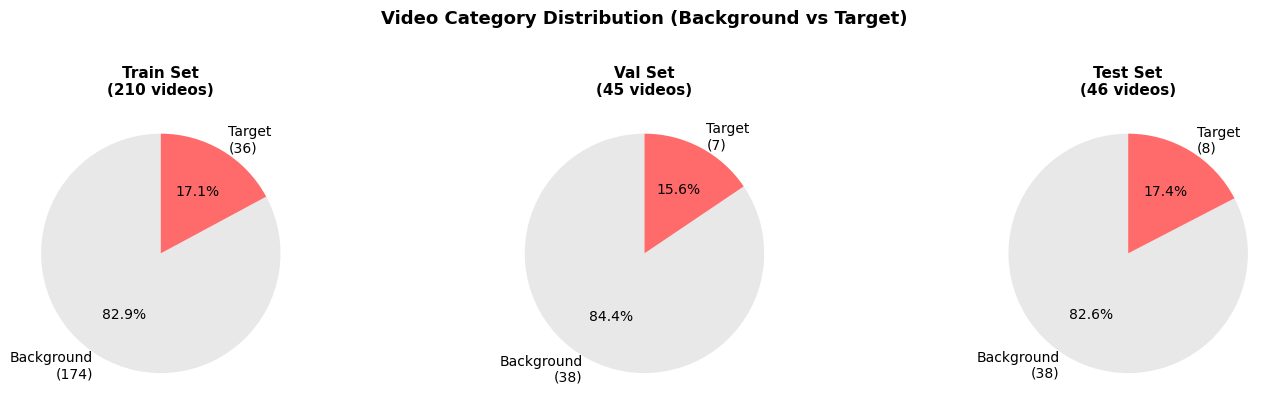

In [10]:
# Visualization 2: Background vs Target video distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

split_dfs = [train_df, val_df, test_df]
split_names = ['Train', 'Val', 'Test']

for idx, (split_df, split_name, ax) in enumerate(zip(split_dfs, split_names, axes)):
    bg_count = (split_df['video_category'] == 'background').sum()
    tg_count = (split_df['video_category'] == 'target').sum()
    
    sizes = [bg_count, tg_count]
    labels = [f'Background\n({bg_count})', f'Target\n({tg_count})']
    colors = ['#E8E8E8', '#FF6B6B']
    
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})
    ax.set_title(f'{split_name} Set\n({len(split_df)} videos)', fontsize=11, fontweight='bold')

plt.suptitle('Video Category Distribution (Background vs Target)', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


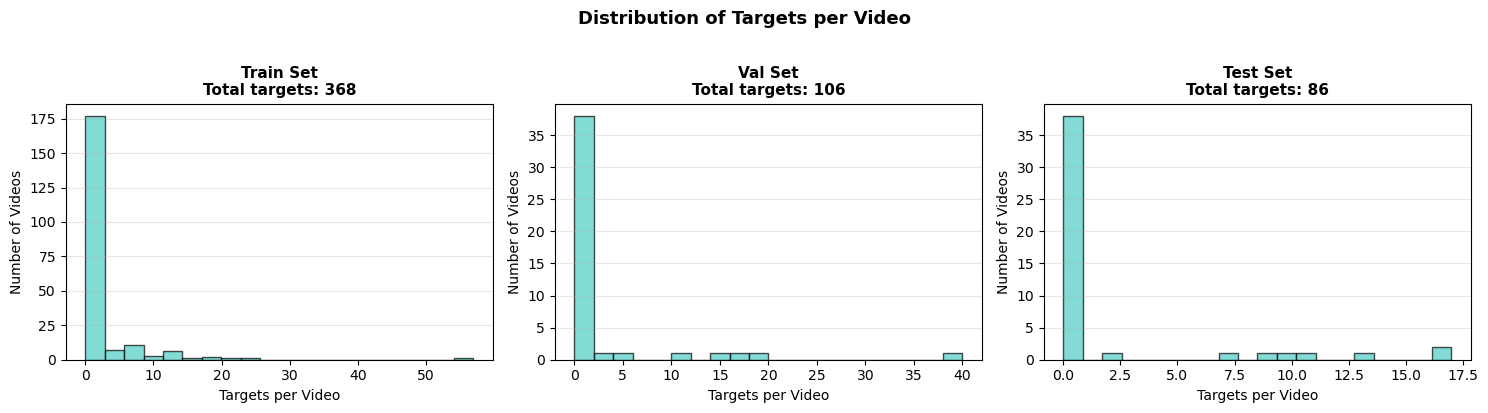

In [11]:
# Visualization 3: Target count distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

split_dfs = [train_df, val_df, test_df]
split_names = ['Train', 'Val', 'Test']

for idx, (split_df, split_name, ax) in enumerate(zip(split_dfs, split_names, axes)):
    total_targets = split_df['total_targets'].sum()
    
    # Create histogram of targets per video
    ax.hist(split_df['total_targets'], bins=20, color='#4ECDC4', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Targets per Video', fontsize=10)
    ax.set_ylabel('Number of Videos', fontsize=10)
    ax.set_title(f'{split_name} Set\nTotal targets: {int(total_targets)}', fontsize=11, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Distribution of Targets per Video', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [12]:
# Summary
print('\n' + '='*80)
print('DATASET SPLIT COMPLETE')
print('='*80)
print(f'\nCSV files created in: {CSV_OUTPUT_DIR}')
print(f'\nSplit Summary:')
print(f'  Train: {len(train_df):3d} videos, {len(train_image_paths):4d} images (70%)')
print(f'  Val:   {len(val_df):3d} videos, {len(val_image_paths):4d} images (15%)')
print(f'  Test:  {len(test_df):3d} videos, {len(test_image_paths):4d} images (15%)')
print(f'  ─────────────────────────────────────')
print(f'  Total: {len(df_videos):3d} videos, {len(df_images):4d} images')

print(f'\nStratification maintained:')
overall_bg = (df_videos['video_category'] == 'background').sum() / len(df_videos) * 100
overall_tg = (df_videos['video_category'] == 'target').sum() / len(df_videos) * 100
print(f'  Overall:  BG={overall_bg:5.1f}%, TG={overall_tg:5.1f}%')
train_bg = (train_df['video_category'] == 'background').sum() / len(train_df) * 100 if len(train_df) > 0 else 0
train_tg = (train_df['video_category'] == 'target').sum() / len(train_df) * 100 if len(train_df) > 0 else 0
val_bg = (val_df['video_category'] == 'background').sum() / len(val_df) * 100 if len(val_df) > 0 else 0
val_tg = (val_df['video_category'] == 'target').sum() / len(val_df) * 100 if len(val_df) > 0 else 0
test_bg = (test_df['video_category'] == 'background').sum() / len(test_df) * 100 if len(test_df) > 0 else 0
test_tg = (test_df['video_category'] == 'target').sum() / len(test_df) * 100 if len(test_df) > 0 else 0
print(f'  Train:    BG={train_bg:5.1f}%, TG={train_tg:5.1f}%')
print(f'  Val:      BG={val_bg:5.1f}%, TG={val_tg:5.1f}%')
print(f'  Test:     BG={test_bg:5.1f}%, TG={test_tg:5.1f}%')

print(f'\nKey guarantees:')
print(f'  ✓ Video-level grouping: All frames from same video stay together')
print(f'  ✓ Stratified split: Background/target ratio maintained across splits')
print(f'  ✓ No duplicates: Each image appears in exactly one split')
print(f'  ✓ Complete coverage: All {len(df_images)} images are included')


DATASET SPLIT COMPLETE

CSV files created in: F:\DeTect_TaiwanBirds_VideoDetector\dataset\csvs\splits

Split Summary:
  Train: 210 videos, 2591 images (70%)
  Val:    45 videos,  545 images (15%)
  Test:   46 videos,  577 images (15%)
  ─────────────────────────────────────
  Total: 301 videos, 3713 images

Stratification maintained:
  Overall:  BG= 83.1%, TG= 16.9%
  Train:    BG= 82.9%, TG= 17.1%
  Val:      BG= 84.4%, TG= 15.6%
  Test:     BG= 82.6%, TG= 17.4%

Key guarantees:
  ✓ Video-level grouping: All frames from same video stay together
  ✓ Stratified split: Background/target ratio maintained across splits
  ✓ No duplicates: Each image appears in exactly one split
  ✓ Complete coverage: All 3713 images are included
